<a href="https://colab.research.google.com/github/PrashantBagri/IP_IIIT_Delhi_2026/blob/main/20260202_ANNDigitalWeights_PB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf              # Core TensorFlow library
from tensorflow import keras         # High-level Keras API for model building
from tensorflow.keras import layers  # Common neural network layers




In [ ]:
# Define the discrete weight levels allowed in the network
# All weights will be forced to take one of these values
LEVELS = tf.constant(
    [0.0, 0.25, 0.75, 1.0],  # Allowed discrete values
    dtype=tf.float32        # Use float32 for TensorFlow compatibility
)


In [ ]:
def quantize_to_levels(x):
    # Ensure values stay within the valid range [0, 1]
    x = tf.clip_by_value(x, 0.0, 1.0)

    # Compute absolute difference between each value in x
    # and every allowed discrete level
    # Result shape: (..., number_of_levels)
    diffs = tf.abs(x[..., tf.newaxis] - LEVELS)

    # Find index of the closest level for each value
    idx = tf.argmin(diffs, axis=-1)

    # Replace each value with its nearest discrete level
    return tf.gather(LEVELS, idx)


In [ ]:
def ste(x, qx):
    # Forward pass: behaves like qx (quantized value)
    # Backward pass: gradient flows as if output was x
    return x + tf.stop_gradient(qx - x)


def ste_sign(x):
    # Compute sign of x: +1 for >= 0, -1 for < 0
    s = tf.where(x >= 0.0, 1.0, -1.0)

    # Apply straight-through estimator so gradients
    # pass through the original continuous value
    return ste(x, tf.cast(s, x.dtype))


In [ ]:
class DigitalDense(layers.Layer):
    """
    Custom dense layer with digital (discrete) weights

    Effective weight = sign * magnitude
    magnitude ∈ {0, 0.25, 0.75, 1}
    sign ∈ {-1, +1}
    """

    def __init__(self, units, use_bias=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units          # Number of output neurons
        self.use_bias = use_bias    # Whether to use bias

    def build(self, input_shape):
        # Number of input features
        in_dim = int(input_shape[-1])

        # Trainable magnitude weights (continuous during training)
        self.w_mag = self.add_weight(
            shape=(in_dim, self.units),
            initializer=keras.initializers.RandomUniform(0.0, 1.0),
            trainable=True,
            name="w_mag"
        )

        # Trainable sign weights (later converted to +1 / -1)
        self.w_sign = self.add_weight(
            shape=(in_dim, self.units),
            initializer=keras.initializers.RandomNormal(stddev=0.05),
            trainable=True,
            name="w_sign"
        )

        # Optional bias term
        self.b = None
        if self.use_bias:
            self.b = self.add_weight(
                shape=(self.units,),
                initializer="zeros",
                trainable=True,
                name="bias"
            )

    def call(self, x):
        # Quantize magnitude using discrete levels with STE
        mag_q = ste(self.w_mag, quantize_to_levels(self.w_mag))

        # Quantize sign to {-1, +1} with STE
        sign_q = ste_sign(self.w_sign)

        # Compute effective digital weights
        w_eff = sign_q * mag_q

        # Standard dense layer operation
        y = tf.matmul(x, w_eff)

        # Add bias if enabled
        if self.b is not None:
            y = y + self.b

        return y


In [ ]:
# Load the MNIST handwritten digit dataset
# x_*  -> images
# y_*  -> corresponding digit labels (0–9)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Convert pixel values to float and normalize to range [0, 1]
# Then flatten each 28x28 image into a vector of length 784
x_train = (x_train.astype("float32") / 255.0).reshape(-1, 784)

# Apply the same preprocessing to the test data
x_test  = (x_test.astype("float32") / 255.0).reshape(-1, 784)


In [ ]:
# Define input layer for flattened MNIST images
inputs = keras.Input(shape=(784,))

# First digital dense block
x = DigitalDense(512)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Second digital dense block
x = DigitalDense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Third digital dense block
x = DigitalDense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Fourth digital dense block
x = DigitalDense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Output layer: 10 classes (digits 0–9)
outputs = DigitalDense(10)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Print model architecture summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense (DigitalDense)    │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_1 (DigitalDense)  │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_2 (DigitalDense)  │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_3 (DigitalDense)  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_4 (DigitalDense)  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,152,970 (4.40 MB)

 Trainable params: 1,151,050 (4.39 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model.compile(
    # Adam optimizer updates weights using adaptive learning rates
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-3   # Step size for weight updates
    ),

    # Loss function for multi-class classification with integer labels
    # from_logits=True because the output layer has NO softmax
    loss=keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ),

    # Metric to report during training and validation
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    x_train,        # Training input data (flattened MNIST images)
    y_train,        # Training labels (true digit for each image)

    batch_size=128, # Number of samples processed before one weight update
    epochs=5,       # Number of full passes over the training dataset

    validation_split=0.1,  # Use 10% of training data for validation
                            # (not used for weight updates)

    verbose=2       # Level of logging:
                    # 0 = silent
                    # 1 = progress bar
                    # 2 = one line per epoch
)


Epoch 1/5
422/422 - 29s - 68ms/step - accuracy: 0.9087 - loss: 0.3126 - val_accuracy: 0.9542 - val_loss: 0.1420
Epoch 2/5
422/422 - 25s - 58ms/step - accuracy: 0.9606 - loss: 0.1282 - val_accuracy: 0.9520 - val_loss: 0.1585
Epoch 3/5
422/422 - 39s - 93ms/step - accuracy: 0.9698 - loss: 0.0950 - val_accuracy: 0.9685 - val_loss: 0.1041
Epoch 4/5
422/422 - 24s - 56ms/step - accuracy: 0.9746 - loss: 0.0786 - val_accuracy: 0.9673 - val_loss: 0.1107
Epoch 5/5
422/422 - 24s - 56ms/step - accuracy: 0.9796 - loss: 0.0644 - val_accuracy: 0.9733 - val_loss: 0.0944


In [ ]:
# Evaluate the trained model on test (unseen) data
test_loss, test_acc = model.evaluate(
    x_test,     # Test images
    y_test,     # True labels for test images
    verbose=0   # 0 = no output during evaluation
)

# Print test accuracy as a standard Python float
print("Test accuracy:", float(test_acc))


Test accuracy: 0.9714000225067139


In [ ]:
# Run a dummy input through the model to force layer building
# This ensures all weights are created and initialized
_ = model(
    tf.zeros([1, 784], dtype=tf.float32)  # One fake MNIST-like input
)


In [ ]:
# Loop through all layers in the model
for layer in model.layers:

    # Check if the layer is a DigitalDense layer
    if isinstance(layer, DigitalDense):

        # Print whether the layer has been built
        print("Layer:", layer.name, "built:", layer.built)

        # Check if magnitude and sign weights exist
        print(
            "Has w_mag:", hasattr(layer, "w_mag"),
            "Has w_sign:", hasattr(layer, "w_sign")
        )

        # Stop after checking the first DigitalDense layer
        break


Layer: digital_dense built: True
Has w_mag: True Has w_sign: True


In [ ]:
# Iterate through model layers
for layer in model.layers:

    # Focus only on DigitalDense layers
    if isinstance(layer, DigitalDense):

        # Quantize magnitudes to discrete levels
        mag_q = quantize_to_levels(layer.w_mag)

        # Convert sign weights to +1 or -1
        sign_q = tf.where(layer.w_sign >= 0.0, 1.0, -1.0)

        # Get unique magnitude values used in the layer
        uniq_mag = tf.sort(
            tf.unique(tf.reshape(mag_q, [-1]))[0]
        )

        # Get unique sign values used in the layer
        uniq_sign = tf.sort(
            tf.unique(
                tf.reshape(tf.cast(sign_q, tf.float32), [-1])
            )[0]
        )

        # Compute effective digital weights
        w_eff = tf.cast(sign_q, tf.float32) * mag_q

        # Get unique effective weight values
        uniq_eff = tf.sort(
            tf.unique(tf.reshape(w_eff, [-1]))[0]
        )

        # Print verification results
        print("Unique magnitudes:", uniq_mag.numpy())
        print("Unique signs:", uniq_sign.numpy())
        print("Unique effective weights:", uniq_eff.numpy())

        # Stop after first DigitalDense layer
        break


Unique magnitudes: [0.   0.25 0.75 1.  ]
Unique signs: [-1.  1.]
Unique effective weights: [-1.   -0.75 -0.25 -0.    0.25  0.75  1.  ]


In [ ]:
import numpy as np

# Number of test samples to visualize
NUM_SAMPLES = 10

# Randomly select indices from the test set (no repeats)
idx = np.random.choice(
    len(x_test),
    NUM_SAMPLES,
    replace=False
)

# Run the model to get raw outputs (logits)
logits = model(
    x_test[idx],
    training=False   # Disable training-specific behavior
)

# Convert logits to probabilities
probs = tf.nn.softmax(
    logits,
    axis=-1
)

# Predicted digit labels (0–9)
pred_labels = tf.argmax(
    probs,
    axis=1
).numpy()

# True digit labels
true_labels = y_test[idx]


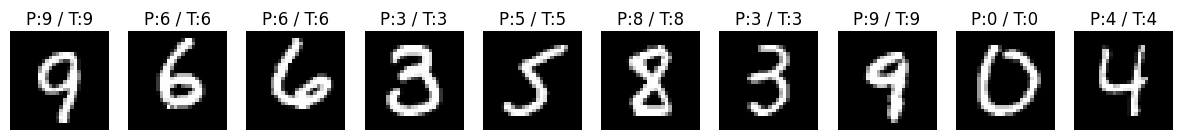

In [ ]:
import matplotlib.pyplot as plt

# Create a wide figure to display multiple images in one row
plt.figure(figsize=(15, 3))

# Loop over selected test samples
for i in range(NUM_SAMPLES):

    # Create subplot: 1 row, NUM_SAMPLES columns
    plt.subplot(1, NUM_SAMPLES, i + 1)

    # Display the test image (reshape back to 28x28)
    plt.imshow(
        x_test[idx[i]].reshape(28, 28),
        cmap="gray"
    )

    # Remove axis ticks for cleaner visualization
    plt.axis("off")

    # Show predicted (P) and true (T) labels
    plt.title(f"P:{pred_labels[i]} / T:{true_labels[i]}")

# Render the figure
plt.show()


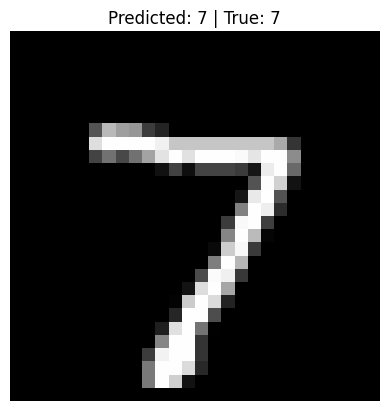

Class probabilities:
 0: 0.0000
 1: 0.0000
 2: 0.0000
 3: 0.0049
 4: 0.0000
 5: 0.0000
 6: 0.0000
 7: 0.9946
 8: 0.0001
 9: 0.0003


In [ ]:
# Choose a specific test image (0 ≤ index < len(x_test))
TEST_INDEX = 0

# Extract the selected image and its true label
image = x_test[TEST_INDEX]
true_label = y_test[TEST_INDEX]

# Run model prediction (add batch dimension)
logits = model(
    tf.expand_dims(image, axis=0),  # Shape: (1, 784)
    training=False                  # Inference mode
)

# Convert logits to probabilities
probs = tf.nn.softmax(logits, axis=-1)[0]

# Get predicted class label
pred_label = tf.argmax(probs).numpy()

# Display the test image
plt.imshow(image.reshape(28, 28), cmap="gray")
plt.axis("off")
plt.title(f"Predicted: {pred_label} | True: {true_label}")
plt.show()

# Print class-wise probabilities
print("Class probabilities:")
for i, p in enumerate(probs.numpy()):
    print(f" {i}: {p:.4f}")


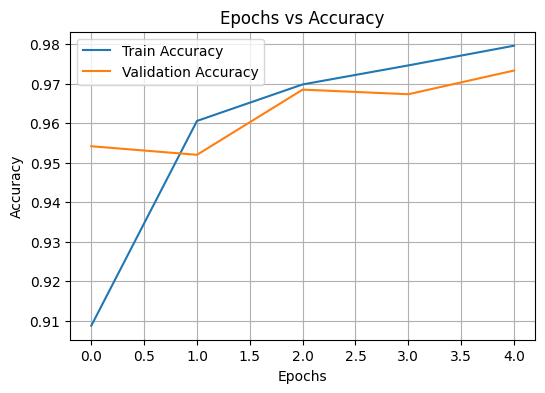

In [ ]:
# Create a new figure for accuracy plot
plt.figure(figsize=(6, 4))

# Plot training accuracy over epochs
plt.plot(history.history["accuracy"], label="Train Accuracy")

# Plot validation accuracy over epochs
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

# Label x-axis as epochs
plt.xlabel("Epochs")

# Label y-axis as accuracy
plt.ylabel("Accuracy")

# Set plot title
plt.title("Epochs vs Accuracy")

# Show legend to distinguish train vs validation
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()


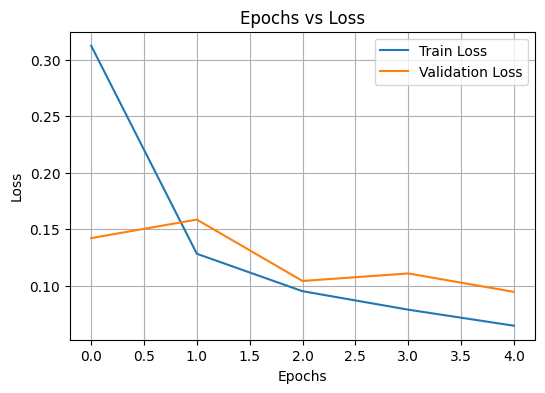

In [ ]:
# Create a new figure for loss plot
plt.figure(figsize=(6, 4))

# Plot training loss over epochs
plt.plot(history.history["loss"], label="Train Loss")

# Plot validation loss over epochs
plt.plot(history.history["val_loss"], label="Validation Loss")

# Label x-axis as epochs
plt.xlabel("Epochs")

# Label y-axis as loss
plt.ylabel("Loss")

# Set plot title
plt.title("Epochs vs Loss")

# Show legend to distinguish train vs validation
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()
